In [2]:
# NOTE: Run this in Python 2.7
import requests
import urllib
import imdb
import lxml.html
import numpy as np
import pandas as pd
import itertools
%matplotlib inline
import seaborn as sns
import math
import matplotlib.pyplot as plt

### Team MovieGnat/NeuralNetFlix

### Milestone 1: Getting to know your data, due Wednesday, April 5, 2017

In the beginning you should get acquainted with the data sources and do some EDA. Sign up for the TMDb [API](https://www.themoviedb.org/documentation/api), and try to download the poster of your favorite movie from within your notebook. Compare the genre entries of IMDb and TMDb for this movie and see if they are the same. Think about and write down some questions that you would like to answer in the following weeks. Keep the storytelling aspect of your final report in mind and do some pen and paper sketches about the visualizations you would like to produce. Include photographs of those sketches in your notebook. 

Most of the time a data scientist spends on a project is spend on cleaning the data. We are lucky that the data we have is already pretty clean. The Python interface to the IMDb ftp files does a lot of the additional work of cleaning as well. However, you will notice that the genre list for each movie from both databases can have different lengths. This needs to be changed in order to train a model to predict the movie genre. It is up to you to think about possible ways to address this problem and to implement one of them. There is no absolute right answer here. It depends on your interests and which questions you have in mind for the project. 

Optionally, you could also scrape additional data sources, such as Wikipedia, to obtain plot summaries. That data may give you additional useful features for genera classification. 

To guide your decision process, provide at least one visualization of how often genres are mentioned together in pairs. Your visualization should clearly show if a horror romance is more likely to occur in the data than a drama romance.

The notebook to submit for this milestone needs to at least include:

- API code to access the genre and movie poster path of your favorite movie
- Genre for this movie listed by TMDb and IMDb
- A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API
- Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them 
- Code to generate the movie genre pairs and a suitable visualization of the result
- Additional visualization sketches and EDA with a focus on movie genres
- A list of questions you could answer with this and related data. Get creative here!

The EDA questions do not necessarily have to tie into the modeling part later on. Think freely about things that might be interesting, like which actors are very specific to a genre? Are action movies more prone to producing sequels than romances? However, as you keep the focus on movie genres, think also about correlations you might discover that can help building features from the metadata for prediction. Is the length of a movie title correlated with genre?


In [3]:
def requestResults(url):
    r = requests.get(BASE_URL + url + "&api_key=" + API_KEY)
    return r.json()

# Constants
BASE_URL = "https://api.themoviedb.org/3/"
API_KEY = "9767d17413ec9d9729c2cca238df02da"
GENRE_MAP = {}
for g in requestResults("genre/movie/list?x=1")[u'genres']:
    GENRE_MAP[g['id']] = g['name']

# Download image
def downloadImageToFile(imgpath, filename):
    # Does not return anything
    urllib.urlretrieve("https://image.tmdb.org/t/p/w500" + imgpath, filename)
    
# Get genre and poster path of one movie by title
def genreAndPosterPath(title):
    title_query = urllib.urlencode({'query': title})
    result = requestResults("search/movie?" + title_query + "&language=en-US&page=1&include-adult=false")[u'results'][0]
    genre_ids = result['genre_ids']
    genres = [str(GENRE_MAP[gid]) for gid in genre_ids]
    poster_path = result['poster_path']
    return genres, poster_path

# Get genres from IMDB for one movie by title
def imdbGenresByTitle(title):
    id_ = imdb_access.search_movie(title)[0].__repr__().split('id:')[1].split('[')[0]
    hxs = lxml.html.document_fromstring(requests.get("http://www.imdb.com/title/tt" + id_).content)
    return hxs.xpath("//a[contains(@href, 'genre')]/text()")[1:]

# Get genres from TMDB for one movie by title
def tmdbGenresByTitle(title):
    title_query = urllib.urlencode({'query': title})
    genre_ids = requestResults("search/movie?" + title_query + "&language=en-US&page=1&include-adult=false")[u'results'][0]['genre_ids']
    return _mapGidsToGenres(genre_ids)

# Private helper function that maps genre_ids to genres
def _mapGidsToGenres(genre_ids):
    return [str(GENRE_MAP[gid]) for gid in genre_ids]

imdb_access = imdb.IMDb()

# EXAMPLES
# requestResults("discover/movie?sort_by=popularity.desc")[u'results'][0] # Get top 10 most popular results
# downloadImageToFile('/tnmL0g604PDRJwGJ5fsUSYKFo9.jpg', 't2s.jpg') # Download an image to the file t2s.jpg

In [4]:
# Genre and movie poster path of your favorite movie from TMDB
fave_movie = 'Logan'

genres, poster_path = genreAndPosterPath(fave_movie)
print 'Fave movie: %s\n================\nGenres: %s\nPoster Path: %s' % (fave_movie, ', '.join(map(str, genres)), poster_path)

Fave movie: Logan
Genres: Action, Drama, Science Fiction
Poster Path: /45Y1G5FEgttPAwjTYic6czC9xCn.jpg


In [5]:
# Genre for this movie listed by TMDb and IMDb
imdb_genres_fave = imdbGenresByTitle(fave_movie)
tmdb_genres_fave = tmdbGenresByTitle(fave_movie)
print 'Genres of fave movie: %s\n================' % fave_movie
print 'IMDB: %s' % ', '.join(map(str, imdb_genres_fave))
print 'TMDB: %s' % ', '.join(map(str, tmdb_genres_fave))

# Challenge: Sci-Fi from IMDB is Science Fiction in TMDB! Need to find a genre mapping between both IMDB and TMDB.

Genres of fave movie: Logan
IMDB:  Action,  Drama,  Sci-Fi,  Thriller
TMDB: Action, Drama, Science Fiction


In [18]:
# A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via TMDB

def top_n_movies_tmdb(N):
    # only 20 results per page so need to send multiple request and increment page number 
    results_per_page = 20.0
    results = []
    num_pages = int(math.ceil(N/results_per_page))
    if num_pages == 1:
        results = requestResults("discover/movie?sort_by=popularity.desc")[u'results'][:N]
    else:
        for n in range(1, num_pages+1):
            result = requestResults("discover/movie?sort_by=popularity.desc&page={}".format(n))
            try:
                r= result[u'results']
                results = results + r
            except KeyError:
                pass

#     return [{'title': str(r['title'].encode('ascii', 'ignore').decode('ascii')), 'genres': _mapGidsToGenres(r['genre_ids'])} for r in results]
#     return [{'title': str(r['title'].encode('ascii', 'ignore').decode('ascii')), 'keywords': get_keywords(int(r[u'id'])), 'genres': _mapGidsToGenres(r['genre_ids'])} for r in results]
    return results
def get_keywords(movieid):
    results = requestResults("movie/{}/keywords?x=1".format(movieid))
    keywords = []
    try:
        k = results[u'keywords']
        keywords = [str(r[u'name'].encode('ascii', 'ignore').decode('ascii')) for r in k]
    except KeyError:
        pass
    return keywords

In [19]:
# get keywords for one movie
get_keywords(321612)

['france',
 'magic',
 'castle',
 'fairy tale',
 'musical',
 'curse',
 'creature',
 'held captive',
 'gothic',
 '18th century',
 'beast']

In [8]:
# Print top 10 movies
top10movies_dict = top_n_movies_tmdb(10)
print 'Top 10 movies and their genres: \n================'
for m in top10movies_dict:
    print '%s: %s' % (m['title'], ', '.join(map(str, m['genres'])))

Top 10 movies and their genres: 
Beauty and the Beast: Fantasy, Music, Romance
Logan: Action, Drama, Science Fiction
Sing: Animation, Comedy, Drama, Family, Music
Kong: Skull Island: Science Fiction, Action, Adventure, Fantasy
Jurassic World: Action, Adventure, Science Fiction, Thriller
Ghost in the Shell: Action, Drama, Science Fiction
Fantastic Beasts and Where to Find Them: Adventure, Action, Fantasy
The Boss Baby: Animation, Comedy, Family
Interstellar: Adventure, Drama, Science Fiction
Finding Dory: Adventure, Animation, Comedy, Family


In [9]:
# genre pair matching between IMDB/TMBD for top 1000 movies 

In [10]:
# Pairs of genres that co occur for movies from TMDB

num_genres = len(GENRE_MAP.keys())
genre_matrix = np.zeros((num_genres, num_genres))

genres = list(map(str, GENRE_MAP.values()))
genre_df = pd.DataFrame(genre_matrix)
genre_df.columns = genres
genre_df.index = genres

In [11]:
# retrieve top 1000 movies
top_1000_movies = top_n_movies_tmdb(1000)
top_1000_movie_genres = map(lambda m: map(str,m['genres']), top_1000_movies)

# # create all pairs of genres
genre_pairs = list(itertools.combinations(genres, 2))
for genre in genres:
    genre_pairs.append(genre)
    
# for each pair find # movies with that pair:
for pair in genre_pairs:
    for movie_genres in top_1000_movie_genres:
        if set(list(pair)).issubset(movie_genres):
            genre_df[pair[0]][pair[1]] += 1
    

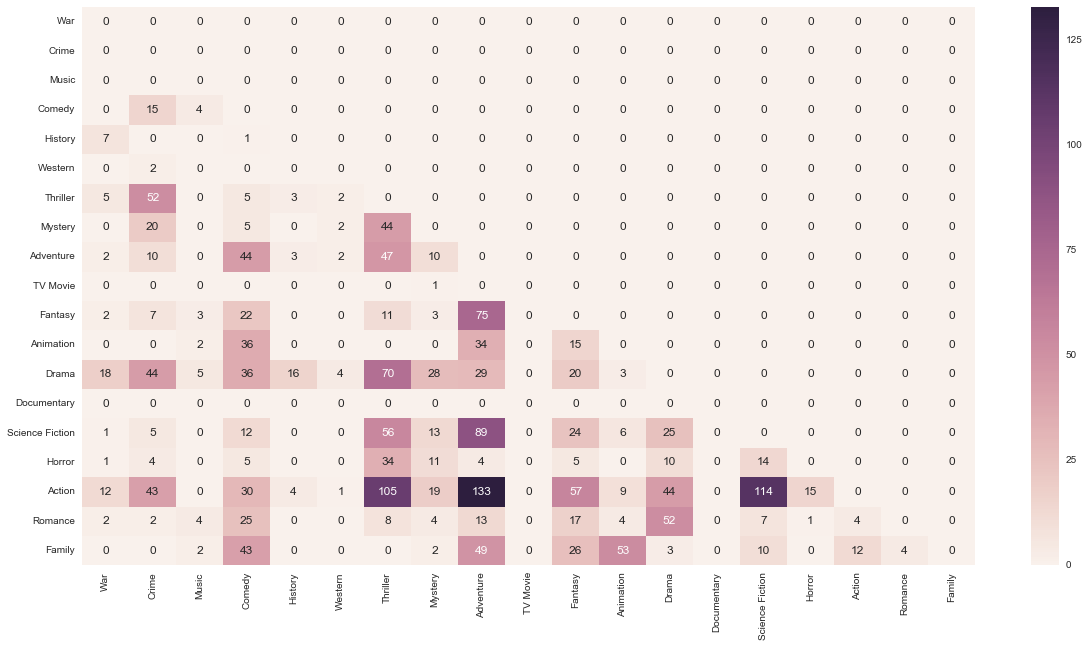

In [12]:
# plot heatmap of movie pairs that co-occur
plt.figure(figsize=(20,10))
sns.heatmap(genre_df, annot=True,fmt="g")

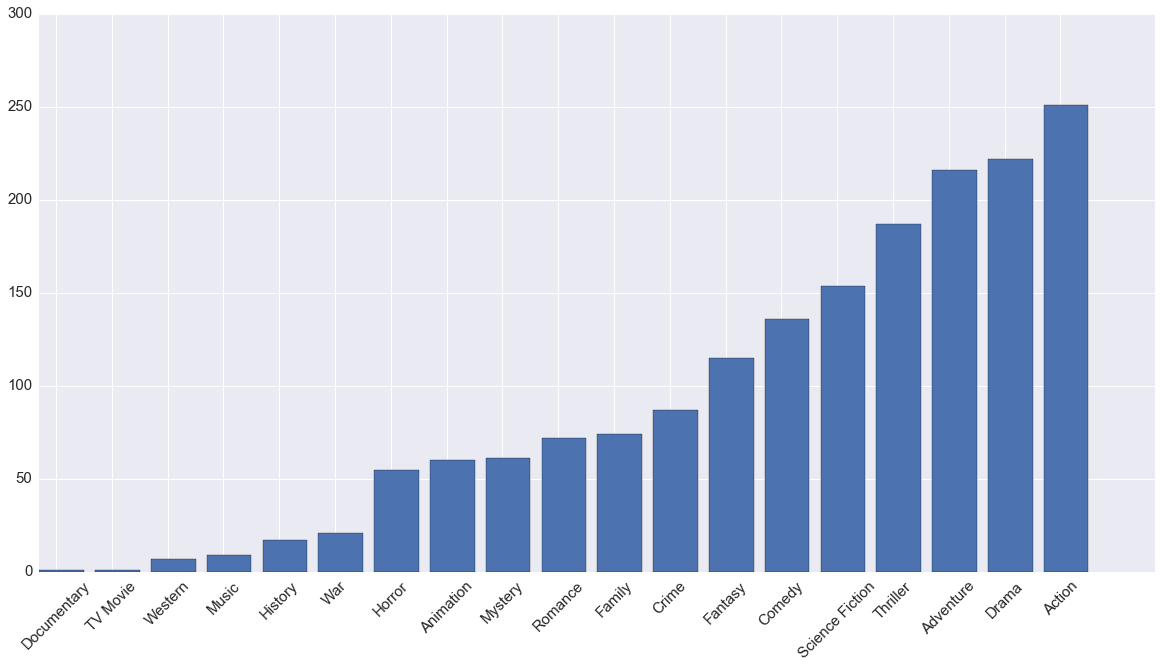

In [13]:
# genre bar chart counts for top 1000 movies
all_genres = list(itertools.chain.from_iterable(top_1000_movie_genres))
genres_unique, all_genres_counts = np.unique(all_genres, return_counts=True)
sorted_counts = [g for (g, c) in sorted(zip(all_genres_counts, genres_unique))]
sorted_genres = [c for (g, c) in sorted(zip(all_genres_counts, genres_unique))]

fig, ax = plt.subplots(figsize=(20, 10))
num_unique_genres = len(all_genres_counts)
ax.bar(range(num_unique_genres), sorted_counts)
ax.set_xticks(np.arange(num_unique_genres)+0.3)
ax.set_xticklabels(sorted_genres, rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [14]:
# keywords by genre
genre_keywords = {}
for genre in genres:
    genre_keywords[genre] = {}

for movie in top_1000_movies:
    for genre in movie['genres']:
        for word in movie['keywords']:
            if not word in genre_keywords[genre]:
                genre_keywords[genre][word] = 1
            else:
                genre_keywords[genre][word] += 1
#         genre_keywords[genre] = genre_keywords[genre].union(movie['keywords'])    

In [15]:
sorted_genre_counts = {}
for genre in genres:
    sorted_genre_counts[genre] = sorted([(value,key) for (key,value) in genre_keywords[genre].items()], reverse=True)

In [16]:
for genre in genres:
    print genre + ' : ' + str([l for l in sorted_genre_counts[genre][:5]])

War : [(5, 'world war ii'), (4, 'war'), (3, 'nazis'), (3, 'biography'), (3, '1940s')]
Crime : [(7, 'based on novel'), (6, 'murder'), (4, 'violence'), (4, 'vigilante'), (4, 'kidnapping')]
Music : [(2, 'singing competition'), (2, 'musical'), (2, 'duringcreditsstinger'), (2, 'castle'), (2, 'beast')]
Comedy : [(15, 'duringcreditsstinger'), (7, 'aftercreditsstinger'), (6, 'woman director'), (6, 'friendship'), (6, '3d')]
History : [(4, 'biography'), (2, 'world war ii'), (2, 'war'), (2, 'japan'), (2, 'based on true story')]
Western : [(1, 'winter'), (1, 'wilderness'), (1, 'violence'), (1, 'survival'), (1, 'snow')]
Thriller : [(17, 'dystopia'), (16, 'based on novel'), (15, 'violence'), (11, 'sequel'), (10, 'murder')]
Mystery : [(4, 'violence'), (4, 'murder'), (4, 'conspiracy'), (4, 'based on novel'), (3, 'shootout')]
Adventure : [(19, 'aftercreditsstinger'), (17, 'sequel'), (17, 'marvel comic'), (16, 'based on comic book'), (15, '3d')]
TV Movie : []
Fantasy : [(9, 'vampire'), (9, 'vamp'), (9, 

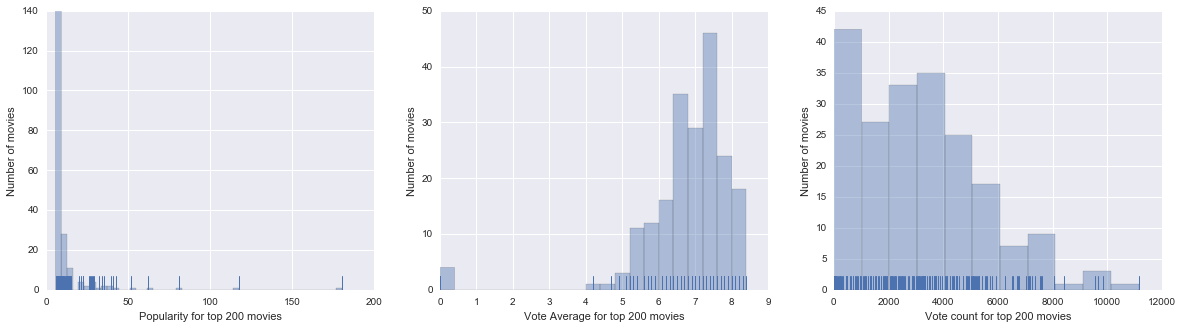

In [20]:
# top 200 movies popularity, average vote count, vote_average

popularity_top200 = []
vote_average_top200 = []
vote_count_top200 = []

top200_movies = []
top200_movies = top_n_movies_tmdb(200)


for movie in top200_movies:
    popularity_top200.append(movie['popularity'])
    vote_average_top200.append(movie['vote_average'])
    vote_count_top200.append(movie['vote_count'])
    
# plot histograms of popularity, vote average and vote count for top 200 movies
fig, axs = plt.subplots(1,3)
fig.set_size_inches(20, 5)
sns.distplot(popularity_top200, kde=False, rug=True, ax=axs[0])
axs[0].set_xlabel('Popularity for top 200 movies')
axs[0].set_ylabel('Number of movies')
sns.distplot(vote_average_top200, kde=False, rug=True, ax=axs[1])
axs[1].set_xlabel('Vote Average for top 200 movies')
axs[1].set_ylabel('Number of movies')
sns.distplot(vote_count_top200, kde=False, rug=True, ax=axs[2])
axs[2].set_xlabel('Vote count for top 200 movies')
axs[2].set_ylabel('Number of movies')

(0, 40)

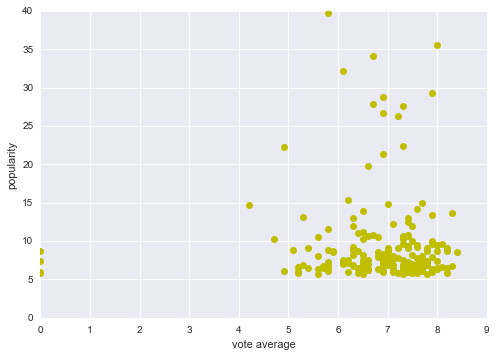

In [77]:
m,b = np.polyfit(vote_average_top200, popularity_top200, 1)
x = vote_average_top200
y = popularity_top200

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 

plt.plot(x,y, 'yo')
plt.xlabel('vote average')
plt.ylabel('popularity')
plt.ylim([0,40])

In [71]:
#adults % by genre
adult = []
genre_adult = dict()
for movie in top200_movies:
    adult_bool = movie['adult']
    adult.append(adult_bool)
    if adult_bool:
        genre_ids = movie['genre_ids']
        for genre_id in genre_ids:
            if genre_id in genre_adult:
                genre_adult[genre_id] += 1
            else:
                genre_adult[genre_id] = 1

In [72]:
print(sum(genre_adult))

0


In [26]:
languages = []
genre_language = dict()
for movie in top200_movies:
    language = str(movie['original_language'])
    if language not in languages:
        languages.append(language)
    else:
        pass
    #genre_ids = movie['genre_ids']
def language_genre(lan):
    #num_movie = 0
    lan_genre = dict()
    for movie in top200_movies:
        language = str(movie['original_language'])
        genre_ids = movie['genre_ids']
        if language == lan:
            #num_movie = num_movie+1
            for genre_id in genre_ids:
                if genre_id in lan_genre:
                    lan_genre[genre_id] += 1
                else:
                    lan_genre[genre_id] = 1     
    return lan_genre

In [40]:
genre_language_map = {}
for lan in languages:
    language_genre_counts = language_genre(lan)
    genre_name_counts = {}
    for key in language_genre_counts:
        genre_name_counts[str(GENRE_MAP[key])] = language_genre_counts[key]
    genre_language_map[lan] = genre_name_counts

In [70]:
genre_language_map

{'el': {'Drama': 1},
 'en': {'Action': 96,
  'Adventure': 84,
  'Animation': 15,
  'Comedy': 30,
  'Crime': 23,
  'Documentary': 1,
  'Drama': 67,
  'Family': 22,
  'Fantasy': 45,
  'History': 7,
  'Horror': 12,
  'Music': 6,
  'Mystery': 22,
  'Romance': 17,
  'Science Fiction': 65,
  'Thriller': 64,
  'War': 7,
  'Western': 5},
 'es': {'Drama': 1, 'Fantasy': 1, 'War': 1},
 'fr': {'Comedy': 1, 'Drama': 1},
 'it': {'Horror': 1},
 'ja': {'Action': 1,
  'Adventure': 1,
  'Animation': 2,
  'Family': 1,
  'Fantasy': 1,
  'Science Fiction': 1},
 'no': {'Drama': 1}}

# Challenges for predicting movie genre based on the data you have, and how to address them

- Imbalanced class proportions - have a lot of movies for action/adventure genre but few for music/western/history

# A list of questions you could answer with this and related data.

- Which genres are popular in which months of the year?
- Which genre pairs get the highest average rating?
- Is movie run time related to genre?
- What keywords characterise a genre?